In [1]:
from pyhive import hive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [5]:
#connecting to rcc
conn = hive.Connection(host = 'hadoop.rcc.uchicago.edu', 
                       port = 10000, 
                       username = 'norahzx', 
                       database = 'dmp_yelp_rs')
cursor = conn.cursor()
query =  'SELECT year(t2.`date`) as year, month(t2.`date`) as month, count(t2.review_id) as review_counts, avg(t2.stars) as avg_stars,t1.simplified_category FROM business_basicdata t1 INNER JOIN review t2 ON t1.business_id = t2.business_id GROUP BY t1.simplified_category, year(t2.`date`), month(t2.`date`)'
cursor.execute(query)
res = cursor.fetchall()


In [92]:
#reading the data into a dataframe
df2 = pd.DataFrame(res, columns = [i[0].split(',')[0] for i in cursor.description])

In [93]:
df2.head()

,year,month,review_counts,avg_stars,t1.simplified_category
0,2006,12,695,3.673381,American
1,2008,9,2840,3.611972,American
2,2010,6,5572,3.603195,American
3,2012,3,8958,3.585399,American
4,2006,10,20,4.400000,Bakery


In [9]:
#re-order the dataframe by year and month
df2 = df2.sort_values(by = ['year','month'])

In [10]:
#change year and month's datatype to string 
df2['Year+Month'] = df2['year'].astype(str) + df2['month'].astype(str)

In [94]:
df2.head()

,year,month,review_counts,avg_stars,t1.simplified_category
0,2006,12,695,3.673381,American
1,2008,9,2840,3.611972,American
2,2010,6,5572,3.603195,American
3,2012,3,8958,3.585399,American
4,2006,10,20,4.400000,Bakery


In [12]:
#to calculate if the average star before covid and after covid is different
df2['star_sum'] = df2['avg_stars'] * df2['review_counts']

In [13]:
#check if the month+year is before covid
def time_test(df2):
    if((df2['year']< 2020 )|((df2['year'] == 2020) & (df2['month'] <2))):
        result = 1
    else:
        result = 0
    return result

In [14]:
df2['if_pre_covid'] = df2.apply(time_test, axis=1)

In [15]:
a = pd.pivot_table(df2.reset_index(),
               index='if_pre_covid', columns='t1.simplified_category', values='star_sum', aggfunc = np.sum
              )
b = pd.pivot_table(df2.reset_index(),
               index='if_pre_covid', columns='t1.simplified_category', values='review_counts', aggfunc = np.sum
              )

covid_diff = a/b

In [16]:
#selecting the categories that shows decrease in scores after covid
score_down = []
for cat in covid_diff.columns:
    #if rating decreased from pre covid time then put into the list
    if covid_diff.iloc[1][cat] > covid_diff.iloc[0][cat]:
        score_down.append(cat)

In [17]:
score_down

['Burgers',
 'Convenience Store',
 'Deli',
 'Fast Food',
 'Grocery',
 'Specialty Food',
 'seafood']

In [18]:
#df2[df2['t1.simplified_category'].isin(score_down)]

,year,month,review_counts,avg_stars,t1.simplified_category,Year+Month,star_sum,if_pre_covid
2957,2005,3,1,4.000000,seafood,20053,4.0,1
4669,2005,3,1,3.000000,Deli,20053,3.0,1
2946,2005,4,1,5.000000,Specialty Food,20054,5.0,1
4108,2005,4,1,3.000000,Fast Food,20054,3.0,1
150,2005,5,1,3.000000,Grocery,20055,3.0,1
...,...,...,...,...,...,...,...,...
1120,2021,1,596,3.766779,Deli,20211,2245.0,0
2049,2021,1,400,3.065000,Grocery,20211,1226.0,0
5002,2021,1,150,4.040000,Specialty Food,20211,606.0,0
5104,2021,1,664,3.891566,seafood,20211,2584.0,0


Text(0.5, 1.0, 'Categories with Ratings Improved since Covid')

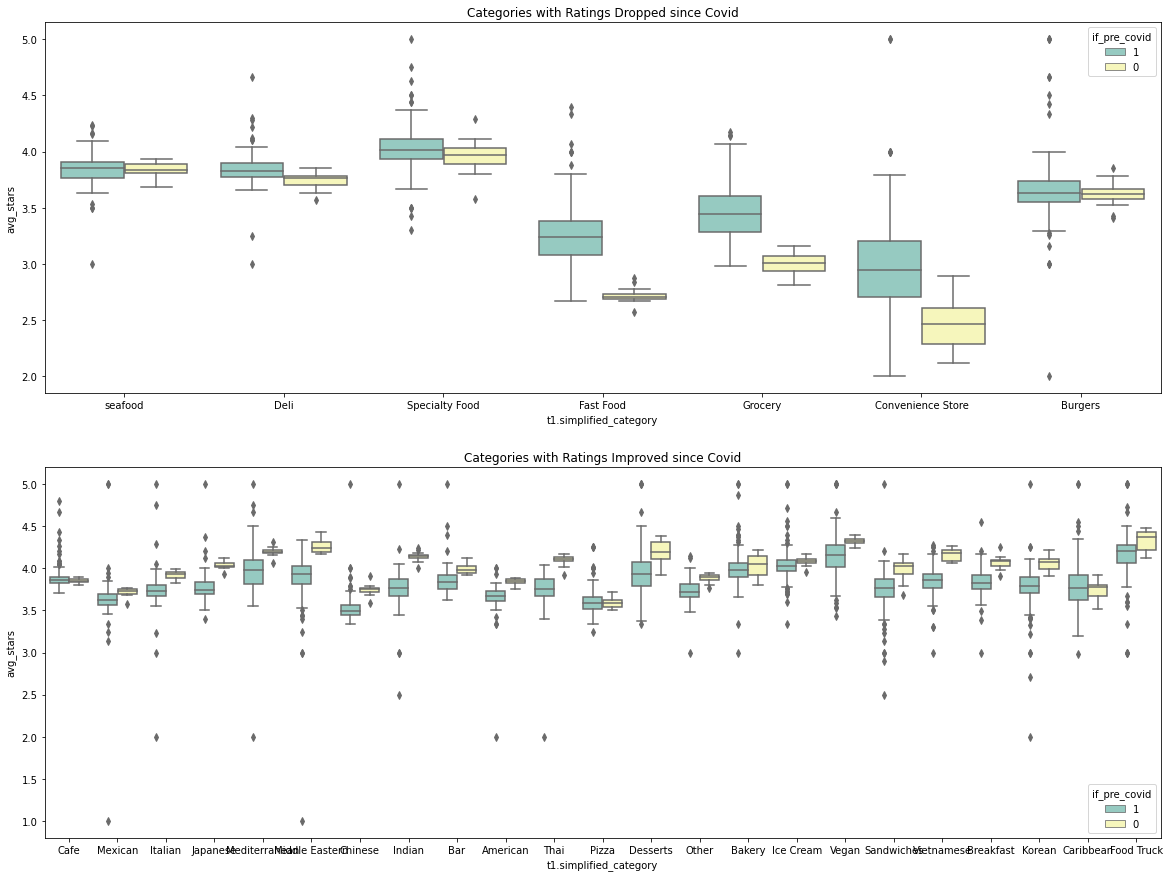

In [19]:
#plotting the avg stars for each category, seprated into improved group and decreased group
plt.rcParams["figure.figsize"]=(20,15)

fig, axes = plt.subplots(2, 1)
ax = sns.boxplot(x="t1.simplified_category", y="avg_stars", hue="if_pre_covid",hue_order = [1,0],
                 data=df2[df2['t1.simplified_category'].isin(score_down)], 
                 palette="Set3",
                ax = axes[0])
axes[0].set_title('Categories with Ratings Dropped since Covid')

ax = sns.boxplot(x="t1.simplified_category", y="avg_stars", hue="if_pre_covid",hue_order = [1,0],
                 data=df2[~df2['t1.simplified_category'].isin(score_down)], 
                 palette="Set3",
                ax = axes[1])
axes[1].set_title('Categories with Ratings Improved since Covid')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Korean'),
  Text(1, 0, 'Fast Food'),
  Text(2, 0, 'Food Truck'),
  Text(3, 0, 'Bakery'),
  Text(4, 0, 'Sandwiches'),
  Text(5, 0, 'Vietnamese'),
  Text(6, 0, 'seafood'),
  Text(7, 0, 'Burgers'),
  Text(8, 0, 'Caribbean'),
  Text(9, 0, 'Vegan'),
  Text(10, 0, 'Middle Eastern'),
  Text(11, 0, 'Mediterranean'),
  Text(12, 0, 'Breakfast'),
  Text(13, 0, 'Convenience Store'),
  Text(14, 0, 'Specialty Food'),
  Text(15, 0, 'Ice Cream'),
  Text(16, 0, 'American'),
  Text(17, 0, 'Other'),
  Text(18, 0, 'Indian'),
  Text(19, 0, 'Italian'),
  Text(20, 0, 'Desserts'),
  Text(21, 0, 'Bar'),
  Text(22, 0, 'Pizza'),
  Text(23, 0, 'Mexican'),
  Text(24, 0, 'Cafe'),
  Text(25, 0, 'Thai'),
  Text(26, 0, 'Chinese'),
  Text(27, 0, 'Grocery'),
  Text(28, 0, 'Deli'),
  Text(29, 0, 'Japanese')])

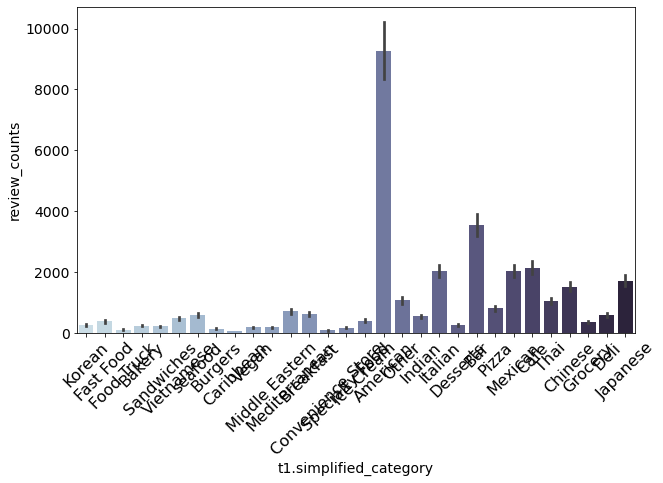

In [95]:
#showing review counts for each category
#sorted_df = df2.sort_values('review_counts')

fig, axes = plt.subplots(1, 1)
plt.rcParams["figure.figsize"]=(10,6)
ax = sns.barplot(x="t1.simplified_category", y="review_counts", 
                 data=sorted_df,
                 #order = sorted_df['t1.simplified_category'],
                 #palette="light:#5A9"
                palette = 'ch:s=.25,rot=-.25')
plt.xticks(rotation=45)

array([<AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+Month'>,
       <AxesSubplot:xlabel='Year+M

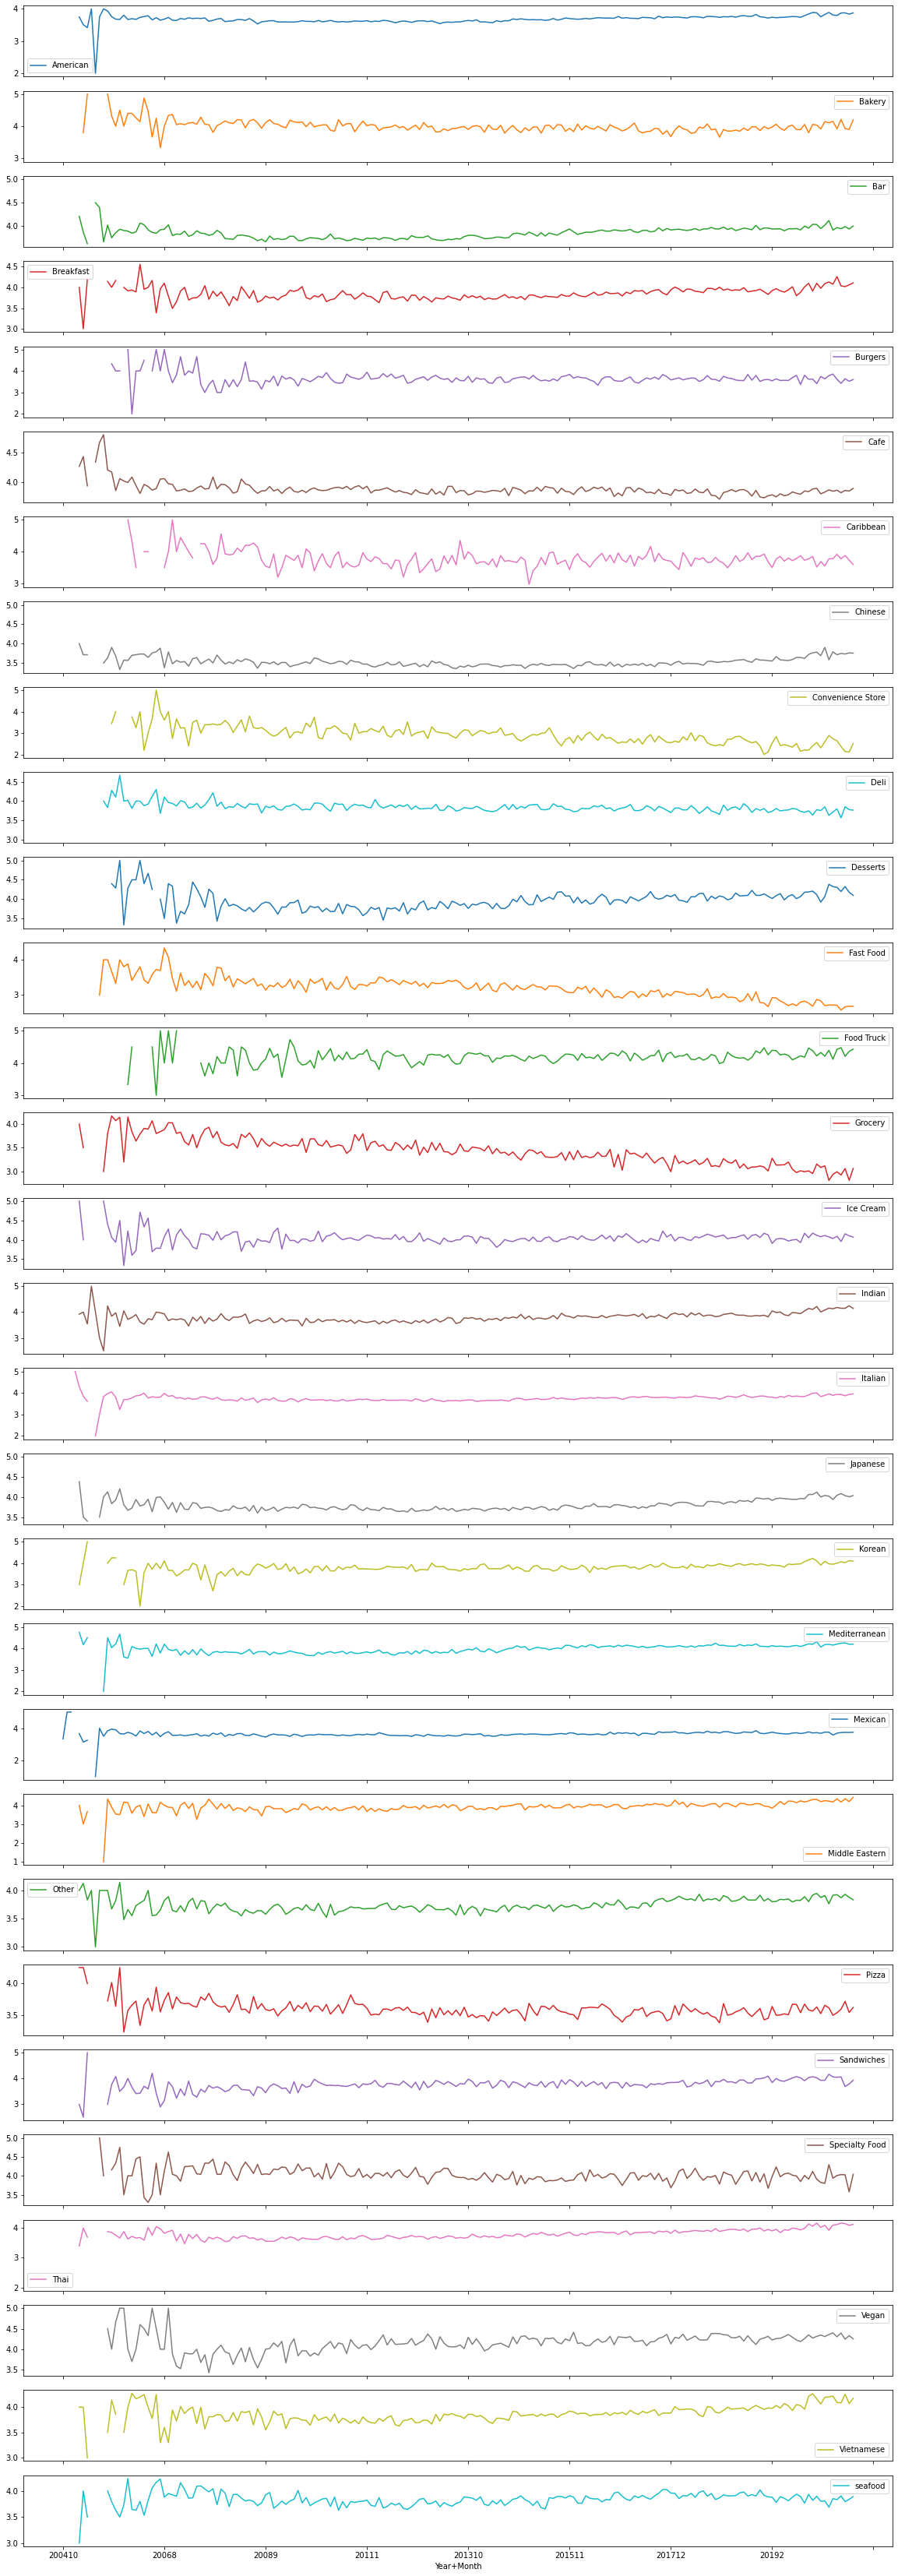

In [22]:
#ploting the review ratings trend for each category
plt.rcParams["figure.figsize"]=(20,60)

#df2.plot(x = 'Year+Month', y = 'avg_stars')

pd.pivot_table(df2.reset_index(),
               index='Year+Month', columns='t1.simplified_category', values='avg_stars'
              ).plot(legend=True, subplots = True)

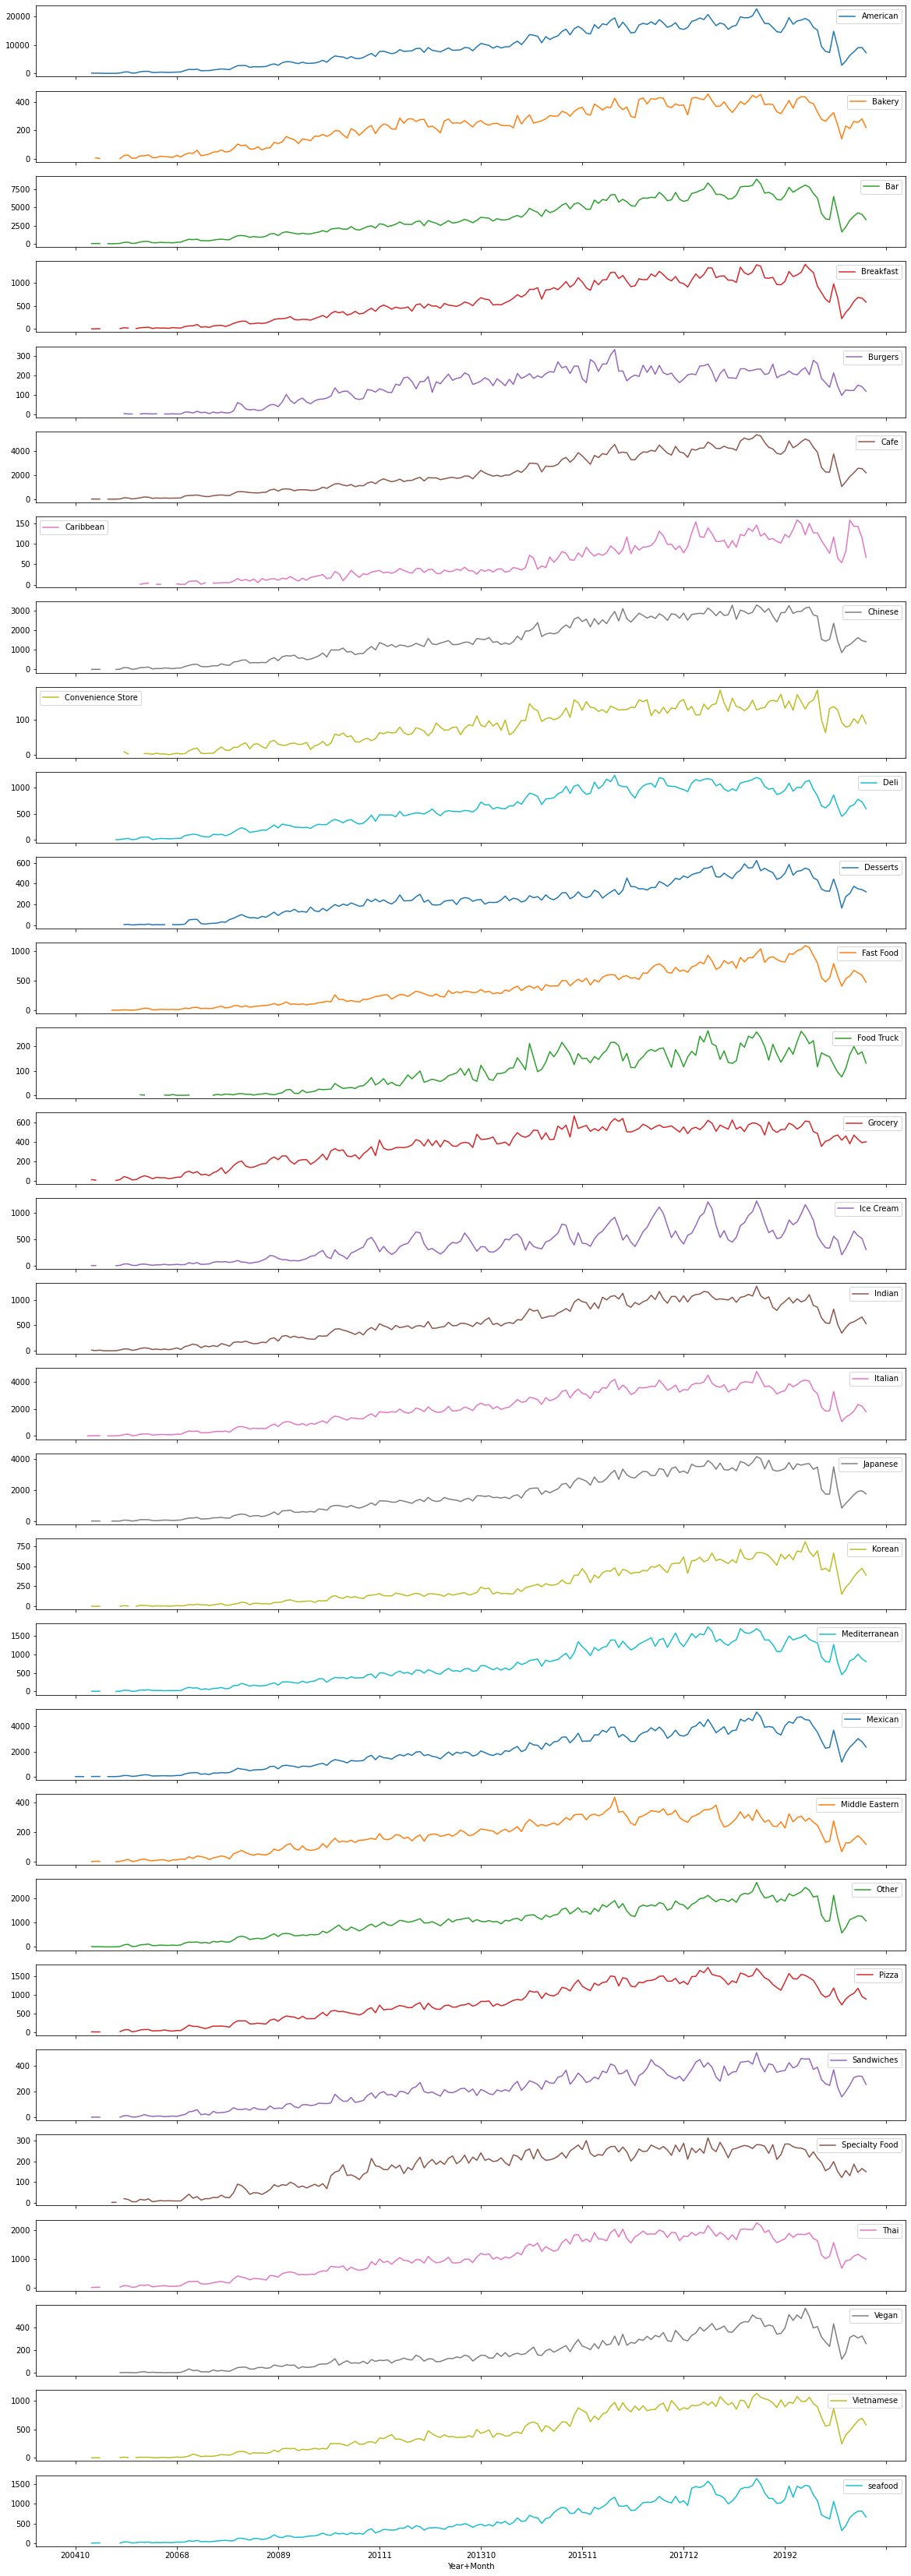

In [23]:
#number of reviews for each category
ax = pd.pivot_table(df2.reset_index(),
               index='Year+Month', columns='t1.simplified_category', values='review_counts'
              ).plot(legend=True, subplots = True)
#plt.axvline(x='20202', color='r', linestyle='--')
#ax.axvline(df2.index.searchsorted('20202'), color="red", linestyle="--", lw=2, label="Covid")
#plt.show()


array([<AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='month'>,
       <AxesSubplot:xlabel='month'>, <AxesSubplot:xlabel='mont

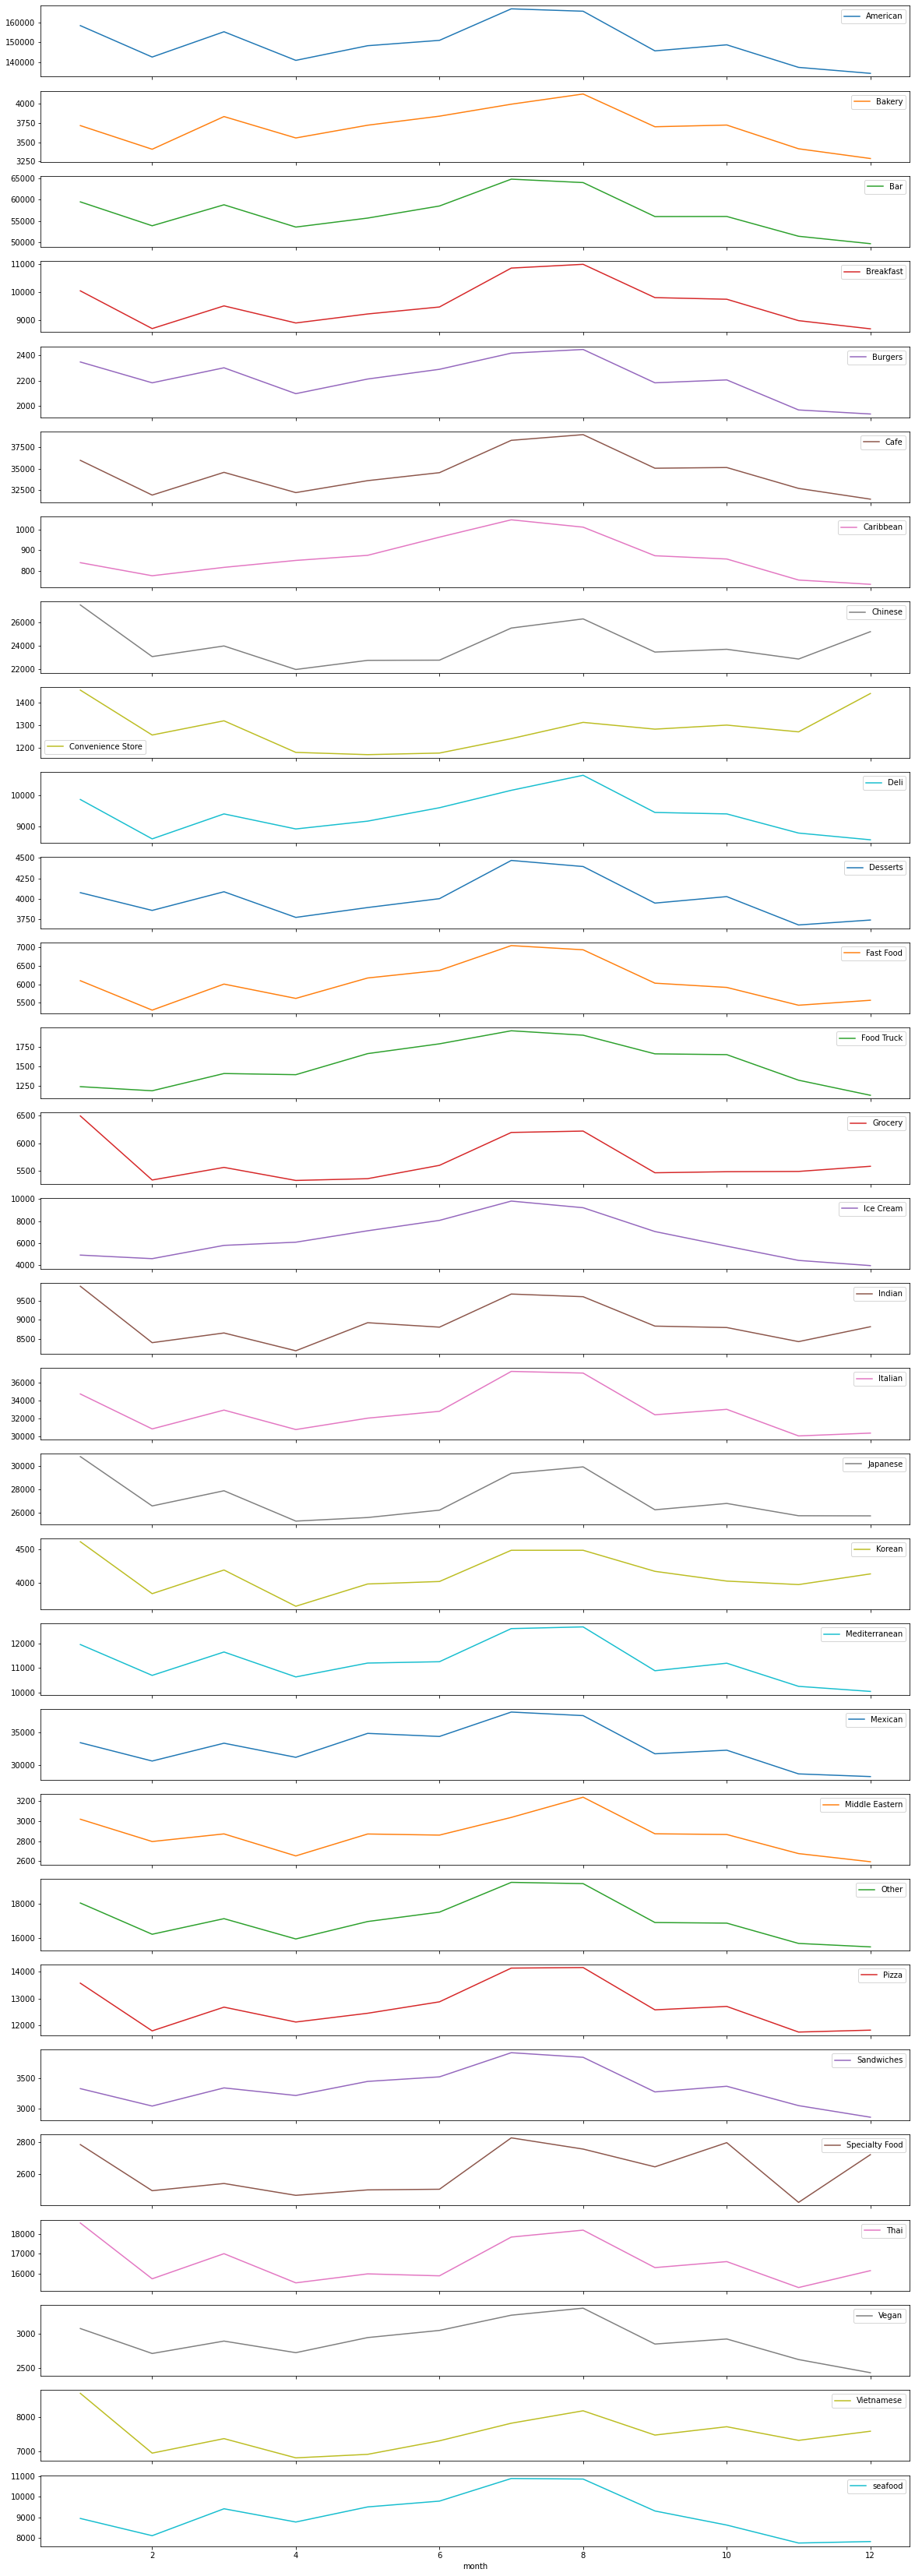

In [24]:
#number of reviews by month for each category
plt.rcParams["figure.figsize"]=(20,60)

pd.pivot_table(df2.reset_index(),
               index='month', columns='t1.simplified_category', values='review_counts', aggfunc = np.sum
              ).plot(legend=True, subplots = True)

In [97]:
#getting only the month, year and review counts data from original dataset
monthly_yearly_all = df2[df2['t1.simplified_category'] == 'American'][['Year+Month','review_counts']].set_index('Year+Month')

In [26]:
monthly_yearly_all.index = pd.to_datetime(monthly_yearly_all.index, format = '%Y%m')

In [27]:
#calculating rolling mean using period 7
rolling_mean = monthly_yearly_all.rolling(7).mean()
rolling_std = monthly_yearly_all.rolling(7).std()

In [28]:
rolling_mean

,review_counts
Year+Month,
2004-10-01,NaN
2004-12-01,NaN
2005-03-01,NaN
2005-04-01,NaN
2005-05-01,NaN
...,...
2020-09-01,3347.428571
2020-10-01,3357.142857
2020-11-01,3615.428571


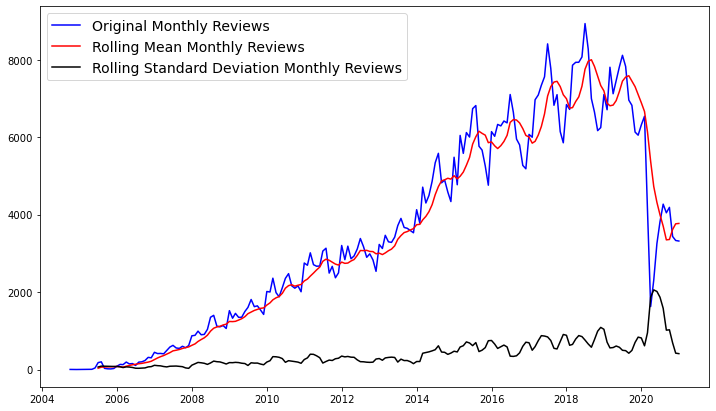

In [46]:
#plotting the rolling mean 
plt.rcParams["figure.figsize"]=(12,7)
#plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

plt.plot(monthly_yearly_all, color = 'blue', label = 'Original Monthly Reviews')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean Monthly Reviews')
plt.plot(rolling_std, color = 'black', label = 'Rolling Standard Deviation Monthly Reviews')
plt.legend(fontsize = 14)
plt.show()

In [47]:
from statsmodels.tsa.stattools import adfuller

In [48]:
#testing for stationality
adft = adfuller(monthly_yearly_all,autolag = 'AIC')

output_df = pd.DataFrame({'Values':[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , 'Metric':['Test Statistics','p-value','No. of lags used','Number of observations used',
'critical value (1%)', 'critical value (5%)', 'critical value (10%)']})
output_df.set_index('Metric')

,Values
Metric,
Test Statistics,-1.644093
p-value,0.460123
No. of lags used,12.000000
Number of observations used,180.000000
critical value (1%),-3.467211
critical value (5%),-2.877735
critical value (10%),-2.575403


In [49]:
#testing for lag correlation 
ac_lag1 = monthly_yearly_all['review_counts'].autocorr(lag = 1)
print('One-Month Lag:', ac_lag1)

ac_lag3 = monthly_yearly_all['review_counts'].autocorr(lag = 3)
print('Three-Month Lag:', ac_lag3)

ac_lag6 = monthly_yearly_all['review_counts'].autocorr(lag = 6)
print('Six-Month Lag:', ac_lag6)

ac_lag9 = monthly_yearly_all['review_counts'].autocorr(lag = 9)
print('Nine-Month Lag:', ac_lag9)

One-Month Lag: 0.9809275551819041
Three-Month Lag: 0.9435191688908339
Six-Month Lag: 0.9160189318710699
Nine-Month Lag: 0.8972632748521628


In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [98]:
#rcParams.items()


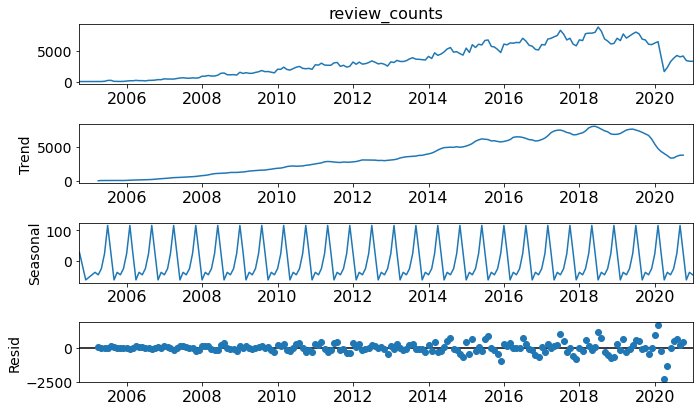

In [91]:
#seasonal decomposition
from pylab import rcParams
plt.rcParams["figure.figsize"]=(10,6)

rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['figure.titlesize'] = 'large'

decompose = seasonal_decompose(monthly_yearly_all['review_counts'], model = 'additive', period = 7)
decompose.plot()
plt.show()

In [71]:
df2.head()

,year,month,review_counts,avg_stars,t1.simplified_category,Year+Month,star_sum,if_pre_covid
1295,2004,10,2,4.000000,Cafe,200410,8.0,1
1425,2004,10,3,3.333333,Mexican,200410,10.0,1
1596,2004,10,4,4.750000,Italian,200410,19.0,1
1689,2004,10,2,5.000000,Japanese,200410,10.0,1
1788,2004,10,5,4.000000,Mediterranean,200410,20.0,1


In [99]:
#df2.groupby(by = 'month').sum()[['review_counts']]

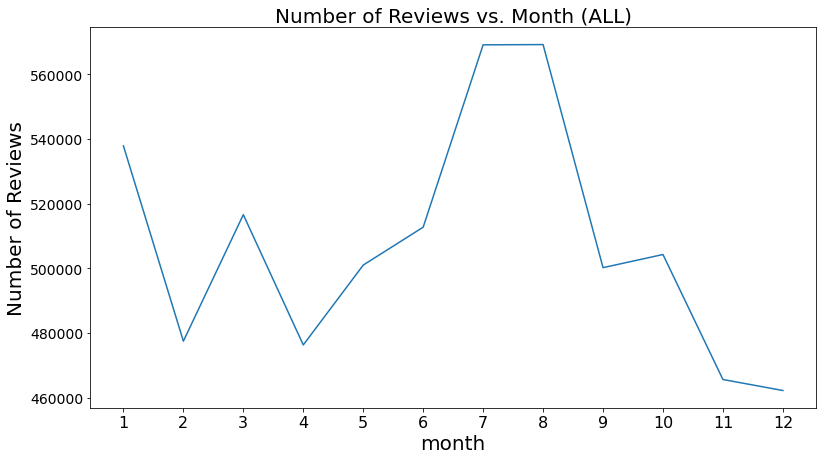

In [88]:
#plotting the total number of reviews against month
plt.rcParams["figure.figsize"]=(13,7)

monthly_all = df2.groupby(by = 'month').sum()[['review_counts']]

plt.plot(monthly_all)
plt.xlabel('month', fontsize = 20)
plt.xticks(monthly_all.index)
plt.ylabel('Number of Reviews', fontsize = 20)
plt.title('Number of Reviews vs. Month (ALL)', fontsize = 20)
plt.show()

In [80]:
#plt.rcParams.keys()